### Note book Two

Compare the survey results for specific items indentified during shoreline surveillance of Lake Geneva. Group survey results in time by Winter, Spring, Summer or Fall, by body of water and municipality.

__Research question:__

_Does the data indicate that shoreline litter densities are seasonal? If so describe the relationship._

#### Contents

1. Automating some things
2. Making a MlwCode class  
3. Dealing with time
4. Grouping by season
5. Plot grouped by season and code

contributors: @hammerdirt, @terborch


### Setting up

Make sure you are running the same packages as this notebook. There is a requirements.txt file for the virutal environment in the [repo](https://github.com/hammerdirt/SWE_2019.git). 

#### Imports

No changes form note book one

In [1]:
import numpy as np
import json
import csv
import datetime
from collections import OrderedDict
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import os
import matplotlib.dates as mdates
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
#import seaborn as sns

In [2]:
# making the file structure
# if you changed the file structure then this function will be problematic

folders = ["Data", "Charts", "Utilities"]
here = os.getcwd()
# never comment this out -- it is used to save output
def make_folders():
    my_folders = {}
    for folder in folders:
        place = here +"/"+ folder
        my_folders[folder] = place
    return my_folders
my_folders = make_folders()

### Making the code class

Gather and compute details for the MLW Codes in a class. 

In [3]:
# Storing the data we used in Notebook one in a class object and
# Creating grouping methods for the class object
variable_names=["beach_info", "get_toys", "get_sheeting", "get_plastics"]

end_point = "http://mwshovel.pythonanywhere.com/dirt/codes/Lac-L%C3%A9man/"

def get_the_data(variable_names,end_points):
    """
    Returns a dictionary with key = vairiable_names
    and value = to JSON output from endpoint
    """
    data = {}
    for i, name in enumerate(variable_names):
        print(variable_names)
        print(end_points[i])
        data[name] = requests.get(end_points[i]).json()
    return data
# make a pieces per meter value for each observation
def get_pieces_per_meter(a_list_of_objects):
    """
    Takes a dictionary not a list. Divides the quantity by the length.
    Creates a new k,v pair with the results    
    """
    new_list_of_objects = []
    the_keys = list(a_list_of_objects.keys())    
    for this_key in the_keys:
        new_list = a_list_of_objects[this_key]
        for the_object in new_list:
            new_object = the_object
            new_object["pcs_m"] = np.round(new_object["quantity"]/new_object["length"], 3)
            new_list_of_objects.append(new_object)
    return new_list_of_objects
# make a summary of the data 
def make_summary(data):
    """
    Makes a summary of the data in dictionary format
    """
    results = {}
    pcs_m = []
    for result in data:
        pcs_m.append(result["pcs_m"])
    results["the_min"] = np.min(pcs_m)
    results["the_max"] = np.max(pcs_m)
    results["the_median"] = np.median(pcs_m)
    results["the_average"] = np.mean(pcs_m)
    results["twenty_fifth"] = np.percentile(pcs_m, 25)
    results["seventy_fifth"] =  np.percentile(pcs_m, 75)
    results["no_samples"] = len(pcs_m)
    results["last_sample"] = max([x["date"] for x in data])
    results["first_sample"] = min([x["date"] for x in data])
    return results
# make time value pairts
def time_value_pairs(aList):
    """
    Makes an array of [time, value] pairs of the 'pcs_m'
    """
    myPairs = [[result['date'], result['pcs_m']] for result in aList]
    return myPairs
#  group by month
def group_values_by_month(aList):
    grouped_by_month = {}
    for x in aList:
        month = x[0].month
        months = grouped_by_month.keys()
        if month in months:
            grouped_by_month[month].append(x)
        else:
            grouped_by_month[month] = [x]
    return grouped_by_month
def group_values_by_month_year(aList):
    grouped_by_month_year = {}
    for x in aList:
        month_year = (x[0].year, x[0].month)
        months_years = grouped_by_month_year.keys()
        if month_year in months_years:
            grouped_by_month_year[month_year].append(x)
        else:
            grouped_by_month_year[month_year] = [x]
    return grouped_by_month_year
def makePythonDate(aList):
    return [[datetime.datetime.strptime(x[0], "%Y-%m-%d"), x[1]] for x in aList.time_value]
def makeSummaryOfAGroup(aDict):
    what_i_want = {}   
    for k,v in aDict.items():
        vals = [x[1] for x in v]
        dates = [x[0] for x in v]
        mean = np.mean(vals)
        median = np.median(vals)
        least = np.min(vals)
        most = np.max(vals)
        count = len(vals)
        first = min(dates)
        last = max(dates)        
        what_i_want.update({k:(v,mean, median, most, least,count, first, last)})       
    return what_i_want
def groupSummary(aMLWCodeClass):
    what_i_want = {}
    the_dates = makePythonDate(aMLWCodeClass)
    by_month_year = group_values_by_month_year(the_dates)
    by_month=group_values_by_month(the_dates)    
    what_i_want.update({"month_year":makeSummaryOfAGroup(by_month_year)})
    what_i_want.update({"month":makeSummaryOfAGroup(by_month)})
    return what_i_want
def makeSeasons(this_data, seasons):
    my_seasons = {}
    my_summaries = []
    for k, v in seasons.items():
        cumulative=[]
        dates = []
        for val in v:
            some_data = this_data[val][0]
            for pair in some_data:
                cumulative.append(pair[1])
                dates.append(pair[0])
        my_seasons.update({k:cumulative})
        mean = np.mean(cumulative)
        median = np.median(cumulative)
        least = np.min(cumulative)
        most = np.max(cumulative)
        count = len(cumulative)
        first = min(dates)
        last = max(dates)
        my_summaries.append({k:{"mean":mean, "median":median, "min":least, "max":most, "samples":count, "first": first, "last":last}})
        
    return( my_seasons, my_summaries)

#### Wrting the class

In [4]:
codes_of_interest =[
    "G32",
    "G67",
    "G82",
    "G79"
]
names=["Toys", "Plastic-sheeting", "Polystyrene", "Broken plastics"]
colors = ["darkmagenta", "darkslategray", "darkorange", "teal"]
def makeStringFromList(aList):
    a_string = ""
    stop_here = len(aList)-1
    for i,obj in enumerate(aList):
        if i == stop_here:
            a_string += "{}".format(obj)
        else:
            a_string += "{}, ".format(obj)
    return a_string
codes_to_print = makeStringFromList(codes_of_interest)
colors_to_print = makeStringFromList(colors)   


print(("The codes of interest are: {}. They are represented\nby the following colors: {}.").format(codes_to_print,colors_to_print))

The codes of interest are: G32, G67, G82, G79. They are represented
by the following colors: darkmagenta, darkslategray, darkorange, teal.


In [5]:
class MlWCodes():
    def __init__(self, code, common_names, end_points):
        self.code = code
        self.data = get_pieces_per_meter(get_the_data(common_names,end_points))
        self.time_value = time_value_pairs(self.data)
        self.summary = make_summary(self.data)


def makeClasessFromCodes(aList):
    what_i_want = []
    for code in codes_of_interest:
        code_class = MlWCodes(code=code, common_names=[code], end_points=[end_point + code])
        what_i_want.append(code_class)
    return what_i_want
i_want_these = makeClasessFromCodes(codes_of_interest)

# if you put more codes in the codes of interest you need to adjust the variables here:
toys, plastic_sheeting, polystyrene, frag_plastic = i_want_these[0], i_want_these[1], i_want_these[2], i_want_these[3]
results_of_interest=[
    toys,
    polystyrene,
    plastic_sheeting,
    frag_plastic    
]    

def makeGroupsFromClasses(aList):
    what_i_want = []
    for x in aList:
        what_i_need = groupSummary(x)
        what_i_want.append(what_i_need)
    return what_i_want
these_too = makeGroupsFromClasses(results_of_interest)
toys_all_grouped, plastic_sheeting_grouped, polystyrene_grouped, frag_platic_grouped = these_too[0], these_too[1], these_too[2], these_too[3]
data_of_interest =[
    toys_all_grouped,
    plastic_sheeting_grouped,
    polystyrene_grouped,
    frag_platic_grouped 
    
]
    
# toys = MlWCodes(code=codes_of_interest[0], common_names=['toys_data'], end_points=[end_point + 'G32'])
# polystyrene = MlWCodes(code=code, common_names=['polystyrene_data'], end_points=[end_point + 'G82'])
# plastic_sheeting = MlWCodes(code=code, common_names=['plastic_sheeting_data'], end_points=[end_point + 'G67'])

['G32']
http://mwshovel.pythonanywhere.com/dirt/codes/Lac-L%C3%A9man/G32
['G67']
http://mwshovel.pythonanywhere.com/dirt/codes/Lac-L%C3%A9man/G67
['G82']
http://mwshovel.pythonanywhere.com/dirt/codes/Lac-L%C3%A9man/G82
['G79']
http://mwshovel.pythonanywhere.com/dirt/codes/Lac-L%C3%A9man/G79


#### Using the class

In [6]:
# get the summary of data for toys
toys.summary

{'the_min': 0.012,
 'the_max': 2.222,
 'the_median': 0.063,
 'the_average': 0.12757894736842101,
 'twenty_fifth': 0.027750000000000004,
 'seventy_fifth': 0.125,
 'no_samples': 76,
 'last_sample': '2019-10-10',
 'first_sample': '2015-11-23'}

### Store summary info in a dataframe:

In [7]:
# create a panda dataframe of the summary to have a nice looking table
# make a function a function from this:
# toys_df = pd.DataFrame(toys.summary, index=[0])
# toys_df = toys_df.join(pd.DataFrame({'code_id': ['G32']}))
# and this:
# pd.DataFrame(plastic_sheeting.summary, index=[0])
# plastic_sheeting = plastic_sheeting.join(pd.DataFrame({'code_id': ['G67']}))


def makeADataFrame(data,code,index):
    aDf= pd.DataFrame(data, index=[index])
    return aDf.join(pd.DataFrame({'code_id': [code]}))
def joinDataFrames(aList, codes_of_interest):
    start = aList[0]
    start_df = makeADataFrame(start.summary,codes_of_interest[0],0)
    for i,data in enumerate(aList[1:]):
        n = i+1
        a_df = makeADataFrame(data.summary,codes_of_interest[n], 0)
        start_df = start_df.append(a_df, ignore_index=True)
    return start_df
        
df_toys_sheeting_styrene = joinDataFrames(results_of_interest, codes_of_interest)
df_toys_sheeting_styrene

,the_min,the_max,the_median,the_average,twenty_fifth,seventy_fifth,no_samples,last_sample,first_sample,code_id
0,0.012,2.222,0.0630,0.127579,0.02775,0.12500,76,2019-10-10,2015-11-23,G32
1,0.016,13.875,0.6600,1.454246,0.22200,1.64100,130,2019-10-10,2015-11-23,G67
2,0.014,6.100,0.2355,0.566918,0.09500,0.54925,110,2019-10-10,2015-11-24,G82
3,0.012,29.056,0.5305,1.391250,0.16275,1.10675,140,2019-10-10,2015-11-23,G79


### Searching, grouping and sorting 

1. Compare summary results from different aggregation levels
2. Group survey results by date range

The MLWCodes class includes an array of results in pcs/m per survey __MLWCodes.time_value__ or the pieces per survey is in __MLWCodes.data__. This holds the results for every instance that the specified code was identified on a survey.


In [8]:
# calling the api and getting the data for:
# All the data and filtering the results on a date
# !! Call this once -- then all the data is stored in a local variable
# no need to make another api call for this location
def getTheDataINeed(a_name="", api_url="", date=""):    
    some_data = get_the_data([a_name],[api_url])
#     print(some_data)
    the_data = get_pieces_per_meter(some_data)
#     print(the_data)
    what_i_want = {}
    if date and a_name:
        what_i_want['the_day'] = [obj for obj in the_data if obj['date'] == date]
        what_i_want[a_name] = the_data            
    elif not date and a_name:
        what_i_want[a_name] = the_data
        
    else:
        print("Wheres my stuff? - there was an error try again")
    return what_i_want
# when you want data for another day just use this
# it will use the local variable 'all_the_days'
def getOtherDays(a_date):
    my_day = list(filter(lambda d: d['date'] == a_date, all_the_days))
    return my_day
def getACategory(a_code, some_data):
    my_code_data = list(filter(lambda d: d['code_id'] == a_code, some_data))
    return my_code_data
def getASetOfUniqueValues(some_attribute, some_data):
    my_special_data = [x[some_attribute] for x in some_data ]
    return list(set(my_special_data))
def getTheValuesOfAnAttribute(some_attribute, attribute_value, some_data):
    my_special_data = [x for x in some_data if x[some_attribute] == attribute_value]
    return my_special_data
# getting all the data for "Parc-des-pierrettes"       
my_data = getTheDataINeed(a_name ="pierrettes", api_url = "http://mwshovel.pythonanywhere.com/dirt/codes/Parc-des-Pierrettes", date="2019-10-10")
the_day, all_the_days = my_data['the_day'], my_data["pierrettes"]
the_second_inventory = getOtherDays("2017-10-05")
the_first_inventory = getOtherDays('2016-10-13')

['pierrettes']
http://mwshovel.pythonanywhere.com/dirt/codes/Parc-des-Pierrettes


#### From here you can store in a dataframe like this:

In [9]:
# or leave it in an array of objects all_the_days
pierretes_all = pd.DataFrame(all_the_days)
pierretes_all.iloc[:3]

,location_id,date,code_id,length,quantity,project_id,owner,pcs_m
0,Parc-des-Pierrettes,2016-10-13,G10,48,1,MCBP,mwshovel,0.021
1,Parc-des-Pierrettes,2016-10-13,G100,48,38,MCBP,mwshovel,0.792
2,Parc-des-Pierrettes,2016-10-13,G125,48,2,MCBP,mwshovel,0.042


#### For just the toys data:

The same for all the other categories previously selected

In [10]:
# you can use the function on all_the_days getTheValuesOfAnAttribute('code_id', 'G32', all_the_days)
# or call getTheValuesOfAnAttribute() on toys.data 
pierretes_all.loc[pierretes_all['code_id'] == 'G32']

,location_id,date,code_id,length,quantity,project_id,owner,pcs_m
20,Parc-des-Pierrettes,2016-10-13,G32,48,6,MCBP,mwshovel,0.125
52,Parc-des-Pierrettes,2017-10-05,G32,42,2,MCBP,mwshovel,0.048
76,Parc-des-Pierrettes,2019-10-10,G32,30,3,tiger-duck,mwshovel,0.100


#### Get date range and all the corresponding values for 'date' of the location:

In [11]:
# using a dataframe:
# using the array of objects: getASetOfUniqueValues('date', all_the_days)
pierretes_all['date'].unique()

array(['2016-10-13', '2017-10-05', '2019-10-10'], dtype=object)

### Get the total number found, the pieces per meter and the 25th, 50th and 75%ile

##### For the codes of interest from all locations on the lake

In [12]:
# for the requested codes at all locations on the lake:
df_toys_sheeting_styrene

,the_min,the_max,the_median,the_average,twenty_fifth,seventy_fifth,no_samples,last_sample,first_sample,code_id
0,0.012,2.222,0.0630,0.127579,0.02775,0.12500,76,2019-10-10,2015-11-23,G32
1,0.016,13.875,0.6600,1.454246,0.22200,1.64100,130,2019-10-10,2015-11-23,G67
2,0.014,6.100,0.2355,0.566918,0.09500,0.54925,110,2019-10-10,2015-11-24,G82
3,0.012,29.056,0.5305,1.391250,0.16275,1.10675,140,2019-10-10,2015-11-23,G79


##### For the codes of interest at the location of interest

In [13]:
# for the requested codes at the location of interest:
def getPandasCodeSummary(df,codes):
    the_dfs = []
    for code in codes:
        a_sum = df.loc[df['code_id'] == code]['pcs_m'].describe()
        a_sum['code_id'] = code
        a_sum = a_sum.to_dict()
        a_df = pd.DataFrame.from_dict([a_sum])       
        the_dfs.append(a_sum)
    what_i_want = pd.DataFrame(the_dfs)
    return what_i_want
pierretes_codes_summaries = getPandasCodeSummary(pierretes_all, codes_of_interest)
pierretes_codes_summaries

,count,mean,std,min,25%,50%,75%,max,code_id
0,3.0,0.0910,0.039281,0.048,0.07400,0.1000,0.11250,0.125,G32
1,2.0,0.2750,0.271529,0.083,0.17900,0.2750,0.37100,0.467,G67
2,2.0,3.9475,2.283248,2.333,3.14025,3.9475,4.75475,5.562,G82
3,3.0,0.9520,1.247298,0.048,0.24050,0.4330,1.40400,2.375,G79


##### For the codes of interest at the location of interest on the day of interest

In [14]:
# for the day of the survey:

day_of_interest = pierretes_all.loc[
    (pierretes_all['code_id'].isin(codes_of_interest)) & (pierretes_all['date'] == '2019-10-10')
][
    ["code_id", "pcs_m", "date"]
].to_dict(orient="records")
pierretes_all.loc[
    (pierretes_all['code_id'].isin(codes_of_interest)) & (pierretes_all['date'] == '2019-10-10')
][
    ["code_id", "pcs_m", "date"]
]

,code_id,pcs_m,date
67,G79,0.433,2019-10-10
70,G67,0.467,2019-10-10
72,G82,2.333,2019-10-10
76,G32,0.100,2019-10-10


##### Research questions:

1. How does the pcs_m value found on that day compare to the results for the whole lake?

Our average piece per meter is lower than the average for the lake, but still withing the standard deviation of approximately 10 for Lake Geneva.
2. What was the probability of finding that value? (given past results)

Considering the mean number of pieces per meter as a random variable, a Gaussian distribution can be used. The probability of having at least 6.37 pieces/m is  equal to 40%.
  this gets answered in notebook three)
3. Does the_max_object for that day fall in the top ten of the whole lake?

The most abundant object of our survey was polystyrene with 70 pieces. Polystyrene is the second most abundant object in Lake Geneva (15% of total pieces in Lake Geneva).
4. How do the codes of interest compare to the previous results?

Previously, on the beach of Parc des Pierrettes there was a toy density of 0.13 toys/m in 2016 and 0.05 toys/m in 2017. The toy density of our survey was 0.1 toys/m (3 toys on 30m).
For all the surveys performed on beaches of lake Geneva about 0.12 toys per meter were found in average (considering only the surveys with at least 1 toy). This corresponds well to the toy density found for our survey.

  * see below

##### __Given the previous results, do you feel the latest survey results were predictable? How would you go about predicting values in the future?__
The latest survey results seem to fit the mean results found on beaches of Lake Geneva quite well.
For predicting values in the future, all conducted surveys have to be taken into account. It should be analysed wheter there is a significant general trend (e.g. overall decreasing amount of pieces per m), then a trendline can be fitted and the future values can be predicted. To make better predictions, the characteristics of a certain beach also have to be taken into account, e.g. if much litter tends to accumulate on a certain beach. This can however only be done if enough surveys have been conducted on that beach and would not be possible for our beach Plage des pierrettes with only 3 conducted surveys.


### Dealing with time

2. Identify which, if any, may have a seasonal variation
3. Determine the method to verify seasonal variation

The _MLWCodes_ class includes a *.time_value_ method*. It retturns a list of lists that are stored like this:

\[\[date, pcs_m\], \[date, pcs_m\],... \[date, pcs_m\]\]

__Where 'date' and 'pcs_m' are real values from the database__ for every instance that the object of interest was identified. 

##### grouped by month  -- all values from all years that fall within a particular month

In [15]:
print("the tenth month")
toys_all_grouped["month"][10]

the tenth month


([[datetime.datetime(2016, 10, 13, 0, 0), 0.125],
  [datetime.datetime(2016, 10, 13, 0, 0), 0.125],
  [datetime.datetime(2017, 10, 5, 0, 0), 0.25],
  [datetime.datetime(2017, 10, 5, 0, 0), 0.048],
  [datetime.datetime(2017, 10, 22, 0, 0), 0.071],
  [datetime.datetime(2018, 10, 16, 0, 0), 2.222],
  [datetime.datetime(2019, 10, 10, 0, 0), 0.1]],
 0.4201428571428572,
 0.125,
 2.222,
 0.048,
 7,
 datetime.datetime(2016, 10, 13, 0, 0),
 datetime.datetime(2019, 10, 10, 0, 0))

##### grouped by year and month 

In [16]:
print("the tenth month of 2016")
toys_all_grouped["month_year"][(2016,10)]

the tenth month of 2016


([[datetime.datetime(2016, 10, 13, 0, 0), 0.125],
  [datetime.datetime(2016, 10, 13, 0, 0), 0.125]],
 0.125,
 0.125,
 0.125,
 0.125,
 2,
 datetime.datetime(2016, 10, 13, 0, 0),
 datetime.datetime(2016, 10, 13, 0, 0))

In [17]:
# supress scientific notation for numpy array display
np.set_printoptions(suppress=True)
# set default precision when printing numpy arrays
np.set_printoptions(precision=3)

### Is there a seasonal variation?

Seasons of the year are defined in the MLW guidelines. For the purposes of this analysis the seasons of the year will be defined as follows:

1. winter: December, january, February
2. spring: March, April, May
3. summer:June, July, August
4. fall: Sepetember, October, November

Start by looking at the results aggregated by month.

In [18]:
# required variables
rows = 3
columns = 4
data = data_of_interest[0]
months = {
    1:"Jan",
    2:"Feb",
    3:"Mar",
    4:"Apr",
    5:"May",
    6:"Jun",
    7:"Jul",
    8:"Aug",
    9:"Sep",
    10:"Oct",
    11:"Nov",
    12:"Dec",
}
width = 0.8
group_by = "month"
obj_name = names[0]
seasons = {
    "winter":[12,1,2],
    "spring":[3,4,5],
    "summer":[6,7,8],
    "fall":[9,10,11]
    
}

seasons_colors = {
    "winter":"cyan",
    "spring":"lime",
    "summer":"saddlebrown",
    "fall":"darkgoldenrod",
}
def getValueOfInterestFromDayOfInterest(day_of_interest, code_of_interest):
    for value in day_of_interest:
        if code_of_interest == value["code_id"]:
            myday_y = value['pcs_m']
            my_date = datetime.datetime.strptime(value['date'], "%Y-%m-%d")
            my_month = my_date.month
    return myday_y, my_month
code_of_interest = codes_of_interest[0]
# for value in day_of_interest:
#     if code_of_interest == value["code_id"]:
#         myday_y = value['pcs_m']
#         my_date = datetime.datetime.strptime(value['date'], "%Y-%m-%d")
#         my_month = my_date.month
myday_y, my_month = getValueOfInterestFromDayOfInterest(day_of_interest, code_of_interest)    
the_title = "{}, code: {}, all locations 2015-2018 Lake Geneva\n".format(obj_name, code_of_interest)
file_name = "{}byMonthBoxPlot".format(code_of_interest)
show = True


def monthlyResults(rows, columns,data, months,myday_y, my_month, group_by, width, obj_name, colors, show):
    fig, ax = plt.subplots(rows,columns, figsize=(8,11), sharey=True)

    rows = np.arange(rows)
    num_samps = 0
    
    for i,group in enumerate([data]):
        the_data = group[group_by]    
        box_plots=[]
        scatter_this = []
        positions = list(the_data.keys())
        for k,v in the_data.items():
            y = [x[1] for x in v[0]]
            box_plots.append(y)
            x = [1 + (np.random.rand(1)*width-width/2.) for x in y]
            scatter_this.append({k:(x,y)})
        box_plots = [value for group in box_plots for value in group]
        box_plots_sorted = sorted(box_plots)
        y_limit = box_plots_sorted[-2]+.1
        scatter_sorted = sorted(scatter_this, key = lambda obj: list(obj.keys())[0] )
        for n,pairs in enumerate(scatter_sorted):        
            if n < 4:
                axs = ax[0,n]
            elif 4 <= n < 8:
                index = {4:0,5:1,6:2,7:3}
                axs = ax[1,index[n]]
            elif 8 <= n <= 11:
                index = {8:0,9:1,10:2,11:3}
                axs = ax[2,index[n]]
            axs.set_ylim(-.1,y_limit)
            box_plot_median = np.percentile(box_plots_sorted, .5)
            axs.boxplot(box_plots, showfliers=False, widths=width)
            for k,v in pairs.items():
                if k in [1,5,9]:
                    axs.scatter(v[0], v[1], color=colors[i], s=100, edgecolor="w", alpha=0.7,label=obj_name)
                    axs.set_xticklabels([months[k]], fontsize=14)
                    y_label_text = '{} per meter'.format(obj_name)
                    axs.set_ylabel(y_label_text, fontsize=12)
                else:
                    axs.scatter(v[0], v[1], color=colors[i], s=100, edgecolor="w", alpha=0.7,label=obj_name)
                    axs.set_xticklabels([months[k]], fontsize=14)
                if my_month == k:
                    axs.scatter(1 + (np.random.rand(1)*width-width/2.),  myday_y, color="r", s=125, label="Day of interest")
        num_samps = len(box_plots)

    the_title_2 = "Grouped by month of the year, n={}".format(num_samps)
    insert_title = '{}{}'.format(the_title, the_title_2)
    plt.suptitle(insert_title, fontweight="book", fontfamily="sans-serif", fontsize=14, linespacing=1.5)
    plt.legend()
    plt.subplots_adjust(top=0.9)
    # plt.tight_layout()
    save_to = my_folders["Charts"] +"/"+ file_name  +".svg"
    plt.savefig(save_to)
    if show:
        plt.show()
        plt.close()
    else:
        plt.close()
        return "Chart saved to {}".format(save_to)

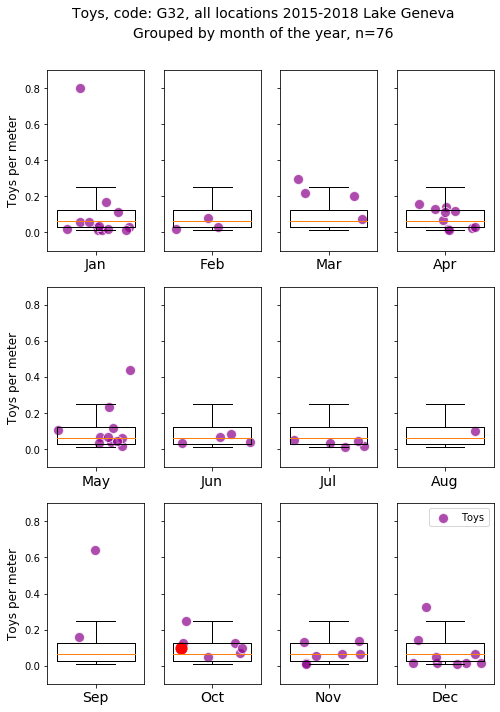

In [19]:
show = True
monthlyResults(rows, columns,data, months, myday_y, my_month, group_by, width, obj_name, colors, show)

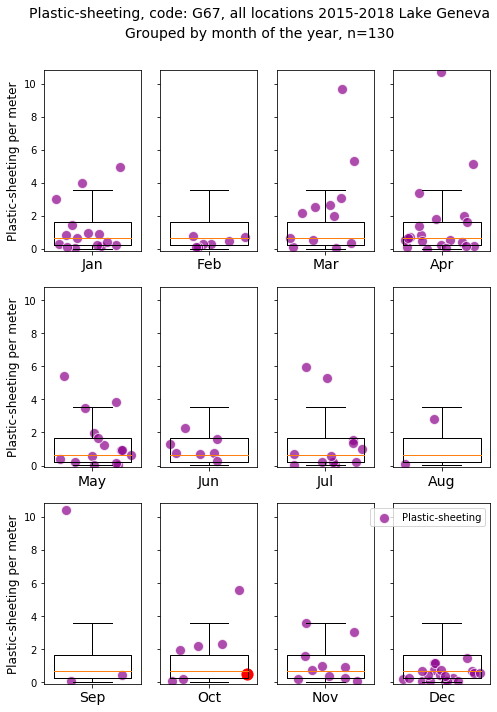

In [20]:
index_number = 1
obj_name = names[index_number]
code_of_interest = codes_of_interest[index_number]
the_title = "{}, code: {}, all locations 2015-2018 Lake Geneva\n".format(obj_name, code_of_interest)
file_name = "{}byMonthBoxPlot".format(code_of_interest)
show = True
data = data_of_interest[index_number]
myday_y, my_month = getValueOfInterestFromDayOfInterest(day_of_interest, code_of_interest)
monthlyResults(rows, columns,data, months, myday_y, my_month, group_by, width, obj_name, colors, show)

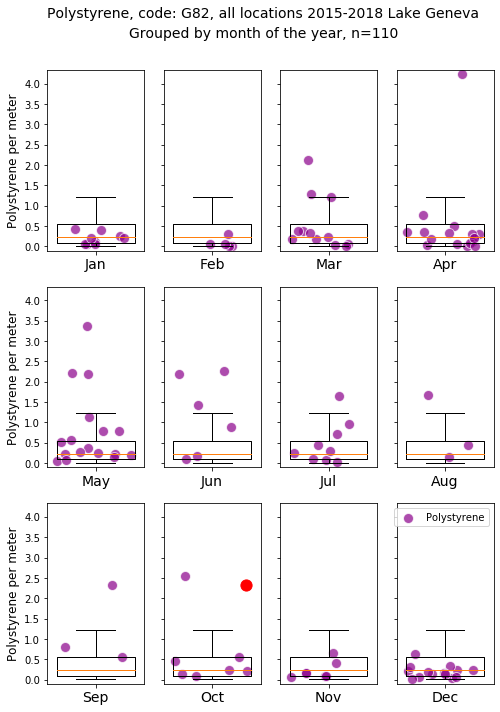

In [21]:
index_number = 2
obj_name = names[index_number]
code_of_interest = codes_of_interest[index_number]
the_title = "{}, code: {}, all locations 2015-2018 Lake Geneva\n".format(obj_name, code_of_interest)
file_name = "{}byMonthBoxPlot".format(code_of_interest)
show = True
data = data_of_interest[index_number]
myday_y, my_month = getValueOfInterestFromDayOfInterest(day_of_interest, code_of_interest)
monthlyResults(rows, columns,data, months, myday_y, my_month, group_by, width, obj_name, colors, show)

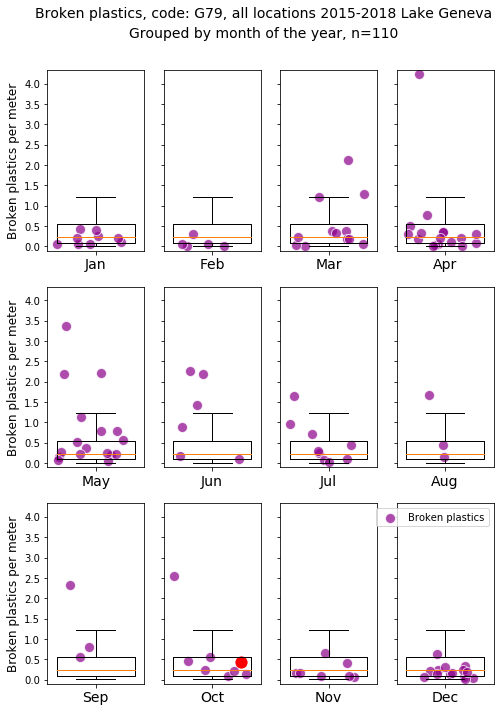

In [22]:
index_number = 3

obj_name = names[index_number]
code_of_interest = codes_of_interest[index_number]
the_title = "{}, code: {}, all locations 2015-2018 Lake Geneva\n".format(obj_name, code_of_interest)
file_name = "{}byMonthBoxPlot".format(code_of_interest)
show = True
myday_y, my_month = getValueOfInterestFromDayOfInterest(day_of_interest, code_of_interest)
monthlyResults(rows, columns,data, months, myday_y, my_month, group_by, width, obj_name, colors, show)

### Codes of interest by seasons of the year:

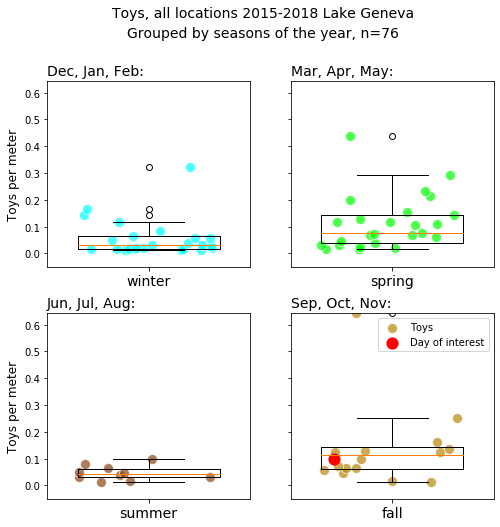

'Chart saved to C:\\Users\\Anna\\Documents\\EPFL_Faecher\\Solid Waste Engineering\\Project\\SWE_2019/Charts/G32bySeaonBoxPlot.svg'

In [23]:
# use this number to cycle throgh the objects of interest:
index_number = 0
rows = 2
columns = 2
width = .7
obj_name = names[index_number]
this_data = data_of_interest[index_number]["month"]
my_seasons, my_summary = makeSeasons(this_data, seasons)
code_of_interest = codes_of_interest[index_number]
the_title = "{}, all locations 2015-2018 Lake Geneva\n".format(obj_name, code_of_interest)
file_name = "{}bySeaonBoxPlot".format(code_of_interest)
for value in day_of_interest:
    if code_of_interest == value["code_id"]:
        myday_y = value['pcs_m']
        my_date = datetime.datetime.strptime(value['date'], "%Y-%m-%d")
        my_month = my_date.month
# show = False
# data = data_of_interest[1]
def seasonalBoxPlots(my_seasons, seasons, myday_y, my_month, the_title, file_name):
    fig, ax = plt.subplots(rows,columns, figsize=(8,8), sharey=True)
    num_samps = 0
    the_seasons = list(my_seasons.keys())
    num_samps = 0
    for i,season in enumerate(the_seasons):
        data_sorted = sorted(my_seasons[season])
        num_samps += len(data_sorted)
        if i < 2:
            axs = ax[0,i]
        if i >= 2:
            key = {2:0, 3:1}
            axs = ax[1,key[i]]
        y = data_sorted
        x = [1 + (np.random.rand(1)*width-width/2.) for x in y]
        if i == 0 or i == 2:
            y_label_text = '{} per meter'.format(obj_name)
            axs.set_ylabel(y_label_text, fontsize=12)
        winter = seasons[season]
        season_months = [months[x] for x in winter]
        ax_title = makeStringFromList(season_months)+":"
        y_limit = data_sorted[-2]
        axs.set_ylim(-.05,y_limit)
        axs.boxplot(data_sorted, widths=width)
        axs.scatter(x,y, color=seasons_colors[season], s=100, edgecolor="w", alpha=0.7,label=obj_name)
        if my_month in winter:
            axs.scatter(1 + (np.random.rand(1)*width-width/2.),  myday_y, color="r", s=125, label="Day of interest")
        axs.set_xticklabels([season], fontsize=14)
        axs.set_title(ax_title, ha="left", x=0, fontsize=14)


    the_title_2 = "Grouped by seasons of the year, n={}\n".format(num_samps)

    insert_title = '{}{}'.format(the_title, the_title_2)
    plt.suptitle(insert_title, fontweight="book", fontfamily="sans-serif", fontsize=14, linespacing=1.5)
    plt.legend()
    plt.subplots_adjust(top=0.85, hspace=0.25)
    # plt.tight_layout()
    save_to = my_folders["Charts"] +"/"+ file_name  +".svg"
    plt.savefig(save_to)
    
    plt.show()
    plt.close()
    return "Chart saved to {}".format(save_to)
    # if show:
# else:
#     plt.close()
#     
seasonalBoxPlots(my_seasons, seasons, myday_y, my_month, the_title, file_name)

In [24]:
print("The summary data for each season:")
for obj in my_summary:    
    for k, v in obj.items():
        print(k)
        print(v)

The summary data for each season:
winter
{'mean': 0.08684000000000001, 'median': 0.033, 'min': 0.012, 'max': 0.8, 'samples': 25, 'first': datetime.datetime(2015, 12, 4, 0, 0), 'last': datetime.datetime(2018, 1, 23, 0, 0)}
spring
{'mean': 0.11312000000000001, 'median': 0.075, 'min': 0.016, 'max': 0.438, 'samples': 25, 'first': datetime.datetime(2016, 3, 14, 0, 0), 'last': datetime.datetime(2018, 5, 8, 0, 0)}
summer
{'mean': 0.047299999999999995, 'median': 0.041499999999999995, 'min': 0.012, 'max': 0.1, 'samples': 10, 'first': datetime.datetime(2016, 6, 17, 0, 0), 'last': datetime.datetime(2018, 7, 22, 0, 0)}
fall
{'mean': 0.264, 'median': 0.1125, 'min': 0.012, 'max': 2.222, 'samples': 16, 'first': datetime.datetime(2015, 11, 23, 0, 0), 'last': datetime.datetime(2019, 10, 10, 0, 0)}


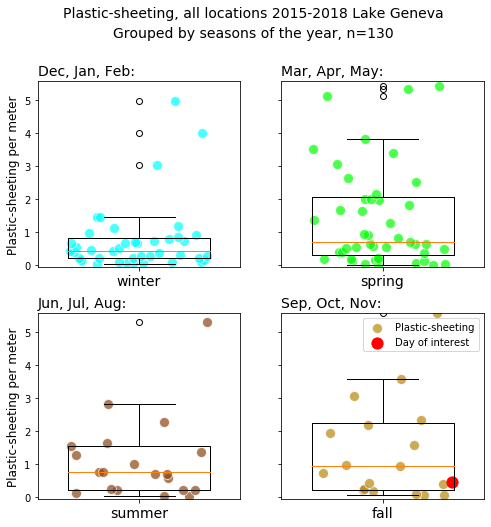

'Chart saved to C:\\Users\\Anna\\Documents\\EPFL_Faecher\\Solid Waste Engineering\\Project\\SWE_2019/Charts/G67bySeaonBoxPlot.svg'

In [25]:
index_number = 1
rows = 2
columns = 2
width = .7
obj_name = names[index_number]
this_data = data_of_interest[index_number]["month"]
my_seasons, my_summary = makeSeasons(this_data, seasons)
code_of_interest = codes_of_interest[index_number]
the_title = "{}, all locations 2015-2018 Lake Geneva\n".format(obj_name, code_of_interest)
file_name = "{}bySeaonBoxPlot".format(code_of_interest)
myday_y, my_month = getValueOfInterestFromDayOfInterest(day_of_interest, code_of_interest)
seasonalBoxPlots(my_seasons, seasons, myday_y, my_month, the_title, file_name)

In [26]:
print("The summary data for each season:")
for obj in my_summary:    
    for k, v in obj.items():
        print(k)
        print(v)

The summary data for each season:
winter
{'mean': 1.0436976744186048, 'median': 0.442, 'min': 0.049, 'max': 13.875, 'samples': 43, 'first': datetime.datetime(2015, 12, 1, 0, 0), 'last': datetime.datetime(2018, 2, 26, 0, 0)}
spring
{'mean': 1.732978723404256, 'median': 0.714, 'min': 0.016, 'max': 10.719, 'samples': 47, 'first': datetime.datetime(2016, 3, 10, 0, 0), 'last': datetime.datetime(2018, 5, 4, 0, 0)}
summer
{'mean': 1.322095238095238, 'median': 0.75, 'min': 0.033, 'max': 5.929, 'samples': 21, 'first': datetime.datetime(2016, 6, 5, 0, 0), 'last': datetime.datetime(2018, 7, 22, 0, 0)}
fall
{'mean': 1.8399473684210523, 'median': 0.935, 'min': 0.074, 'max': 10.429, 'samples': 19, 'first': datetime.datetime(2015, 11, 23, 0, 0), 'last': datetime.datetime(2019, 10, 10, 0, 0)}


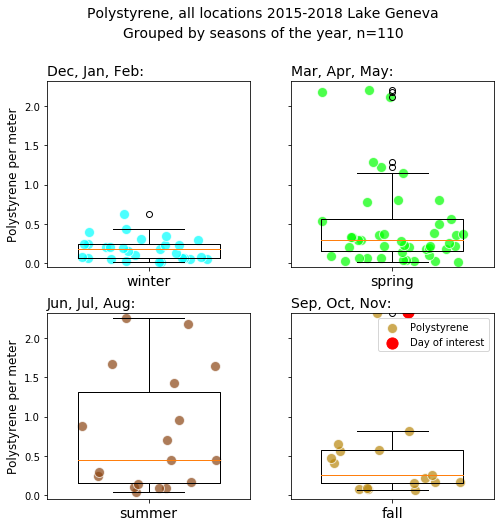

'Chart saved to C:\\Users\\Anna\\Documents\\EPFL_Faecher\\Solid Waste Engineering\\Project\\SWE_2019/Charts/G82bySeaonBoxPlot.svg'

In [27]:
index_number = 2
rows = 2
columns = 2
width = .7
obj_name = names[index_number]
this_data = data_of_interest[index_number]["month"]
my_seasons, my_summary = makeSeasons(this_data, seasons)
code_of_interest = codes_of_interest[index_number]
the_title = "{}, all locations 2015-2018 Lake Geneva\n".format(obj_name, code_of_interest)
file_name = "{}bySeaonBoxPlot".format(code_of_interest)
myday_y, my_month = getValueOfInterestFromDayOfInterest(day_of_interest, code_of_interest)
seasonalBoxPlots(my_seasons, seasons, myday_y, my_month, the_title, file_name)

In [28]:
print("The summary data for each season:")
for obj in my_summary:    
    for k, v in obj.items():
        print(k)
        print(v)

The summary data for each season:
winter
{'mean': 0.38396551724137923, 'median': 0.174, 'min': 0.014, 'max': 6.1, 'samples': 29, 'first': datetime.datetime(2015, 12, 4, 0, 0), 'last': datetime.datetime(2018, 2, 26, 0, 0)}
spring
{'mean': 0.6057391304347827, 'median': 0.28900000000000003, 'min': 0.014, 'max': 4.235, 'samples': 46, 'first': datetime.datetime(2016, 3, 11, 0, 0), 'last': datetime.datetime(2018, 5, 8, 0, 0)}
summer
{'mean': 0.7651111111111111, 'median': 0.447, 'min': 0.033, 'max': 2.262, 'samples': 18, 'first': datetime.datetime(2016, 6, 5, 0, 0), 'last': datetime.datetime(2018, 7, 22, 0, 0)}
fall
{'mean': 0.5641176470588235, 'median': 0.25, 'min': 0.058, 'max': 2.556, 'samples': 17, 'first': datetime.datetime(2015, 11, 24, 0, 0), 'last': datetime.datetime(2019, 10, 10, 0, 0)}


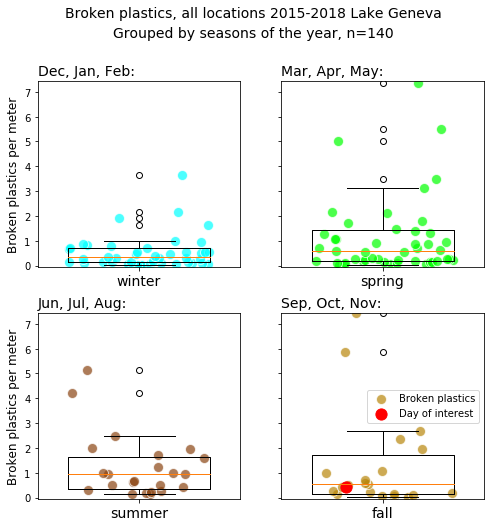

'Chart saved to C:\\Users\\Anna\\Documents\\EPFL_Faecher\\Solid Waste Engineering\\Project\\SWE_2019/Charts/G79bySeaonBoxPlot.svg'

In [29]:
index_number = 3
rows = 2
columns = 2
width = .7
obj_name = names[index_number]
this_data = data_of_interest[index_number]["month"]
my_seasons, my_summary = makeSeasons(this_data, seasons)
code_of_interest = codes_of_interest[index_number]
the_title = "{}, all locations 2015-2018 Lake Geneva\n".format(obj_name, code_of_interest)
file_name = "{}bySeaonBoxPlot".format(code_of_interest)
myday_y, my_month = getValueOfInterestFromDayOfInterest(day_of_interest, code_of_interest)
seasonalBoxPlots(my_seasons, seasons, myday_y, my_month, the_title, file_name)

In [30]:
print("The summary data for each season:")
for obj in my_summary:    
    for k, v in obj.items():
        print(k)
        print(v)

The summary data for each season:
winter
{'mean': 0.7132727272727273, 'median': 0.33399999999999996, 'min': 0.019, 'max': 8.2, 'samples': 44, 'first': datetime.datetime(2015, 12, 1, 0, 0), 'last': datetime.datetime(2019, 1, 16, 0, 0)}
spring
{'mean': 1.5632352941176473, 'median': 0.571, 'min': 0.02, 'max': 9.824, 'samples': 51, 'first': datetime.datetime(2016, 3, 10, 0, 0), 'last': datetime.datetime(2018, 5, 8, 0, 0)}
summer
{'mean': 1.2274782608695651, 'median': 0.946, 'min': 0.148, 'max': 5.143, 'samples': 23, 'first': datetime.datetime(2016, 6, 5, 0, 0), 'last': datetime.datetime(2018, 7, 22, 0, 0)}
fall
{'mean': 2.519727272727273, 'median': 0.5405, 'min': 0.012, 'max': 29.056, 'samples': 22, 'first': datetime.datetime(2015, 11, 23, 0, 0), 'last': datetime.datetime(2019, 10, 10, 0, 0)}


### How do your results compare ?